In [207]:
import json
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


In [180]:
#read API key
f = open("./APIKEYS/apikey-model1.json")
model1_api = json.load(f)
f.close()

In [181]:
def getToken():
    API_KEY = model1_api["apikey"]
    token_response = requests.post('https://iam.cloud.ibm.com/identity/token', data={"apikey": API_KEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
    mltoken = token_response.json()["access_token"]
    
    return mltoken

In [182]:
def smooth(y, box_pts=20):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [183]:
def predict(cols,values,mltoken):
    header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

    # NOTE: manually define and pass the array(s) of values to be scored in the next line
    payload_scoring = {"input_data": [{"fields": cols, "values": values}]}

    response_scoring = requests.post('https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/historic_sales_forecast_model2/predictions?version=2021-09-21&version=2021-09-21', json=payload_scoring, headers={'Authorization': 'Bearer ' + mltoken})
    
    print(response_scoring)
    result = [int(i[0]) for i in response_scoring.json()['predictions'][0]['values']]
    
    return result

In [184]:
def forecast_sales(cols,vals):
    try:
        result = predict(cols,vals,mltoken)
    except:
        mltoken = getToken()
        result = predict(cols,vals,mltoken)
    
    return result

In [185]:
mltoken = getToken()

In [186]:
#read main excel sheet
forecast = pd.read_excel('./datasets/model_2/forecast.xlsx')
dataset = pd.read_excel('./datasets/model_2/training.xlsx')

In [190]:
forecast_copy = forecast.copy()
dataset_copy = dataset.copy()

In [189]:
dataset_cols = list(dataset_copy.columns)
dataset_vals = dataset_copy.values.tolist()

In [200]:
original_store_wise_sales_forecast = dict()
original_store_wise_sales = dict()
for store in range(1,21):
    print("Sales for Store {}".format(store),end = " ")
    store_data = dataset_copy[dataset_copy["SCRUB_STORE_NO"] == store]
    sales = store_data["SALES_UNITS"].values.tolist()
    cols = list(store_data.columns)
    vals = store_data.values.tolist()
    predictions = forecast_sales(cols,vals)
    original_store_wise_sales_forecast[store] = {"store data":store_data, "predictions": predictions}
    original_store_wise_sales[store] = {"store data":store_data, "sales": sales}

Sales for Store 1 <Response [200]>
Sales for Store 2 <Response [200]>
Sales for Store 3 <Response [200]>
Sales for Store 4 <Response [200]>
Sales for Store 5 <Response [200]>
Sales for Store 6 <Response [200]>
Sales for Store 7 <Response [200]>
Sales for Store 8 <Response [200]>
Sales for Store 9 <Response [200]>
Sales for Store 10 <Response [200]>
Sales for Store 11 <Response [200]>
Sales for Store 12 <Response [200]>
Sales for Store 13 <Response [200]>
Sales for Store 14 <Response [200]>
Sales for Store 15 <Response [200]>
Sales for Store 16 <Response [200]>
Sales for Store 17 <Response [200]>
Sales for Store 18 <Response [200]>
Sales for Store 19 <Response [200]>
Sales for Store 20 <Response [200]>


In [117]:
store_wise_forecast = dict()
for store in range(1,21):
    print("Forecasting for Store {}".format(store),end = " ")
    store_data = forecast_copy[forecast_copy["SCRUB_STORE_NO"] == store]
    cols = list(store_data.columns)
    vals = store_data.values.tolist()
    predictions = forecast_sales(cols,vals)
    original_store_wise_sales_forecast[store] = {"store data":store_data, "predictions": predictions}

Forecasting for Store 1 <Response [200]>
Forecasting for Store 2 <Response [200]>
Forecasting for Store 3 <Response [200]>
Forecasting for Store 4 <Response [200]>
Forecasting for Store 5 <Response [200]>
Forecasting for Store 6 <Response [200]>
Forecasting for Store 7 <Response [200]>
Forecasting for Store 8 <Response [200]>
Forecasting for Store 9 <Response [200]>
Forecasting for Store 10 <Response [200]>
Forecasting for Store 11 <Response [200]>
Forecasting for Store 12 <Response [200]>
Forecasting for Store 13 <Response [200]>
Forecasting for Store 14 <Response [200]>
Forecasting for Store 15 <Response [200]>
Forecasting for Store 16 <Response [200]>
Forecasting for Store 17 <Response [200]>
Forecasting for Store 18 <Response [200]>
Forecasting for Store 19 <Response [200]>
Forecasting for Store 20 <Response [200]>


In [217]:
def RMSE(store):
    sales = original_store_wise_sales[store]["sales"]
    predictions = original_store_wise_sales_forecast[store]["predictions"]
    
    l = len(sales)
    
    result = None
    
    if l != len(predictions):
        raise "Lenght of sales and predictions do not match"
    else:
        sum_of_difference = 0
        
        for i in range(l):
            sum_of_difference += abs(sales[i] - predictions[i]) ** 2
        
        result = (sum_of_difference/l)**0.5
    
    return result
    

In [227]:
def offError(store):
    sales = original_store_wise_sales[store]["sales"]
    predictions = original_store_wise_sales_forecast[store]["predictions"]
    
    l = len(sales)
    
    result = None
    
    if l != len(predictions):
        raise "Lenght of sales and predictions do not match"
    else:
        sum_of_difference = 0
        
        for i in range(l):
            if sales[i] == 0:
                sales[i] += 0.1
            print((abs(sales[i]-predictions[i])/sales[i])*100)
            sum_of_difference = sum_of_difference + (abs(sales[i]-predictions[i])/sales[i])*100
        
        result = sum_of_difference/l
    
    return result
    

In [228]:
offError(1)

13.175230566534916
24.691358024691358
99.079754601227
57.974683544303794
38.912133891213394
124.86772486772486
10.677618069815194
8.60215053763441
274.496644295302
85.625
368.9075630252101
71.42857142857143
69.66292134831461
40.2948402948403
35.69230769230769
57.49318801089919
178.42105263157896
7.4074074074074066
67.98866855524079
108.80281690140845
91.90751445086705
1.9202363367799113
101.92307692307692
118.34862385321101
66.66666666666666
186.66666666666666
105.5944055944056
113.87096774193549
48.34905660377358
43.67816091954023
89.3470790378007
147.8448275862069
23.608017817371937
63.63636363636363
13.575525812619501
31.880733944954127
46.231155778894475
34.331797235023046
107.3943661971831
51.670951156812336
31.958762886597935
2.218430034129693
16.317365269461078
62.43654822335025
101.04166666666667
212.9032258064516
125.52301255230125
86.66666666666667
29.72972972972973
56.838905775075986
68.75
135.68075117370893
211.76470588235296
36.32075471698113
91.0
24.568965517241377
60.597

12.225705329153605
49.902534113060426
28.433734939759038
7.871720116618077
48.82075471698113
20.74882995319813
40.044742729306485
73.5576923076923
14.779499404052443
6.796116504854369
28.775510204081634
16.867469879518072
15.741935483870966
42.26579520697168
160.47619047619048
16.887417218543046
76.89530685920577
22.93577981651376
15.711645101663585
9.932659932659933
39.8422090729783
119.01840490797547
12.171507607192254
15.834767641996558
3.9301310043668125
25.476190476190474
19.694072657743785
11.496350364963504
10.714285714285714
33.66013071895425
2.04778156996587
10.062893081761008
14.878892733564014
80.74866310160428
15.539739027283511
99.36305732484077
4.264705882352941
22.82608695652174
20.595238095238095
5.657708628005658
38.57142857142858
12.792792792792792
10.961214165261383
95.8974358974359
39.50177935943061
20.80808080808081
14.000000000000002
31.781376518218625
20.61482820976492
63.44647519582245
69.1891891891892
57.88177339901478
10.98169717138103
10.7095046854083
84.5108

2962.247523653649

In [172]:
def plot(dataset,original,store_wise_forecast,store,timeframe,column,real=True,smooth_factor = 5):
    data_1 = list()
    data_2 = list()
    original_forecast = list()
    sales_forecast = list()
    
    temp = dataset[dataset["SCRUB_STORE_NO"] == store][column].values.tolist()
    if timeframe == -1:
        data_1 = temp
        original_forecast = original
        original_sales = dataset[dataset["SCRUB_STORE_NO"] == store]["SALES_UNITS"].values.tolist()
    else:
        data_1 = temp[-1*timeframe:]
        original_forecast = original[-1*timeframe:]
        original_sales = dataset[dataset["SCRUB_STORE_NO"] == store]["SALES_UNITS"].values.tolist()[-1*timeframe:]

        
    
    
    data_2 = forecast_copy[forecast_copy["SCRUB_STORE_NO"] == store][column].values.tolist()
    sales_forecast = store_wise_forecast[store]["predictions"]
    
    plt.figure(figsize=(20,6)) #plotting
    plt.axvline(x=len(data_1), c='r', linestyle='--') #size of the training set"
    
    print(len(data_1), len(data_2))
    print(len(original_sales), len(sales_forecast))
    
    temp = data_1
    temp.extend(data_2)
    combined_data = temp
    
    temp = original_forecast
    temp.extend(sales_forecast)
    combined_forecast = temp
    
    

    plt.plot(smooth(combined_data,smooth_factor), label=column) 
    plt.plot(smooth(combined_forecast,smooth_factor), label='Sales Prediction') 
    if real:
        plt.plot(smooth(original_sales,smooth_factor), label='Original Sales')
    plt.title('Time-Series Prediction')
    plt.legend()
    plt.show() 
    

1636 16
1636 16


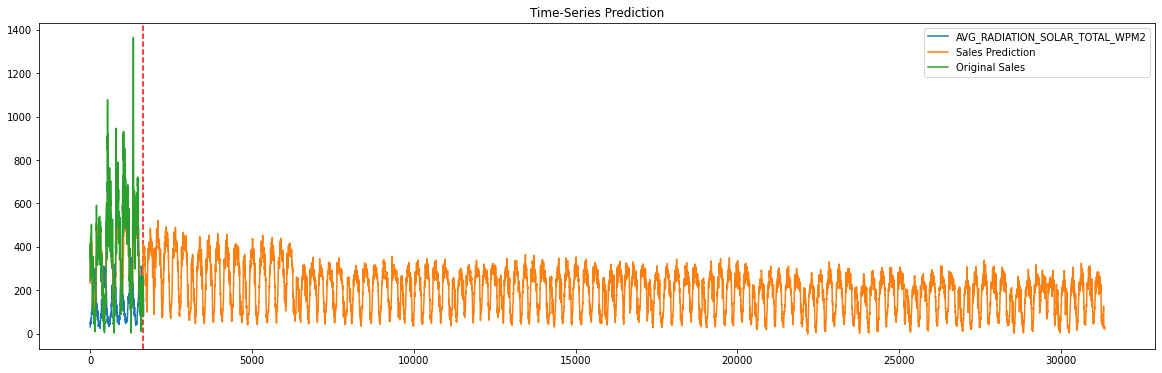

In [173]:
plot(
    dataset,
    original,
    store_wise_forecast,
    store = 1,
    timeframe = -1,
    column = "AVG_RADIATION_SOLAR_TOTAL_WPM2",
    real = True,
    smooth_factor = 10
)

In [176]:
store_wise_forecast[1]["predictions"]

[32, 30, 26, 27, 24, 24, 24, 28, 25, 17, 15, 39, 31, 39, 54, 35]

31353